In [2]:
import os, sys, math, gc
from tqdm import tqdm
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
import seaborn as sns
import lightgbm as lgb
from utils.utils import merge_eval_sold_on_df, sort_df_on_d, WRMSSE, RMSSE, _down_cast, data_preprocessing#create_submission_df
from utils.utils import customIter

from utils.configure_logger import configure_logger
configure_logger()
from logging import getLogger
logger = getLogger(__name__)

from typing import List, Dict

import warnings
warnings.simplefilter("ignore")

In [4]:

DATA_BASE_PATH = "../data/m5-forecasting-accuracy/"
SUBMISSION_BASE_PATH = '../data/accuracy/submissions/'
SALES_EVALUATION = "sales_train_evaluation.csv"
SALES_VALIDATION = "sales_train_validation.csv"
CALENDAR = "calendar.csv"
SAMPLE_SUBMISSION = "sample_submission.csv"
SELL_PRICES = "sell_prices.csv"

DAYS: int = 28
D_START_VAL: int = 1914
D_START_EVAL: int = 1914 + 28

DROP_FEATURE_COLUMNS = ["id", "dept_id", "cat_id", "store_id","state_id", "d", "sold"]

In [3]:
# read all data
sales_validation: pd.DataFrame = _down_cast(pd.read_csv(DATA_BASE_PATH + SALES_VALIDATION))
sales_evaluation: pd.DataFrame = _down_cast(pd.read_csv(DATA_BASE_PATH + SALES_EVALUATION))
calendar: pd.DataFrame = _down_cast(pd.read_csv(DATA_BASE_PATH + CALENDAR))
sample_submission: pd.DataFrame = _down_cast(pd.read_csv(DATA_BASE_PATH + SAMPLE_SUBMISSION))
sell_prices: pd.DataFrame = _down_cast(pd.read_csv(DATA_BASE_PATH + SELL_PRICES))

### Feature Engineering and Cross Validation

In [4]:
df_val, submission_idx_val = data_preprocessing(sales_validation, calendar, sell_prices)
del sales_validation
df_eval, submission_idx_eval = data_preprocessing(sales_evaluation, calendar, sell_prices)
del sales_evaluation

In [5]:
df_val_after_release = df_val[(df_val.wm_yr_wk > df_val.release)]# & (df_val["sold"].notna())]
del df_val
df_eval_after_release = df_eval[(df_eval.wm_yr_wk > df_eval.release)]# & (df_eval["sold"].notna())]

In [6]:
df_val_after_release["d_int"] = df_val_after_release["d"].apply(lambda x: int(x.split("_")[1]))
df_eval_after_release["d_int"] = df_eval_after_release["d"].apply(lambda x: int(x.split("_")[1]))

In [126]:
def compute_features(df: pd.DataFrame, select_first_n_ids: int = None):
    logger.info(f"incoming shape: {df.shape}")
    if select_first_n_ids:
        ids = list(df['id'].unique())[:select_first_n_ids]
        df = df[df['id'].isin(ids)]
        logger.info(f"after selecting first ids: {df.shape}")
        
    df = df[(df.wm_yr_wk > df.release)]
    
    feature_columns = []
    # feature_columns += ["sell_price"]
    
    # precomputing
    df["index"] = df.index
    df["d_int"] = df["d"].apply(lambda x: int(x.split("_")[-1]))
    df["day"] = df.date.dt.day
    
    
    # df['month_temp'] = df['month'].apply(lambda x: (x % 12) + 1)
    # id_month_sold = df.groupby(["id", "month_temp"])["sold"].sum().reset_index(drop=False)
    # id_month_sold.columns = ['id', 'month_temp', 'sold_id_month_m']
    # df['month_temp'] = df['month']
    # df = pd.merge(
    #     left = df,
    #     right = id_month_sold,
    #     on = ['id', 'month_temp'],
    #     how = 'left'
    # )
    # del df['month_temp']
    # feature_columns += ['sold_id_month_m']
    
    # for lag in [1, 7]:
    #     df[f"sold_{lag+1}"] = df.groupby("id")["sold"].shift(lag+1)
    #     feature_columns += [f"sold_{lag+1}"]
        
    def add_ema(df, feature_columns, alpha):
        df[f"sold_id_ema_{str(alpha)}"] = df.groupby("id")["sold"].transform(lambda x: x.ewm(alpha = alpha).mean().shift(1))
        feature_columns += [f"sold_id_ema_{str(alpha)}"]
        return df, feature_columns
    
    df, feature_columns = add_ema(df, feature_columns, .01)
    df, feature_columns = add_ema(df, feature_columns, .05)
    df, feature_columns = add_ema(df, feature_columns, .1)
    
    def add_ema_diff(df, feature_columns, a1, a2):
        df[f'sold_ema_diff_{str(a1)}_{str(a2)}'] = df[f"sold_id_ema_{str(a1)}"] - df[f"sold_id_ema_{str(a2)}"] 
        feature_columns += [f'sold_ema_diff_{str(a1)}_{str(a2)}']
        return df, feature_columns
    
    df, feature_columns = add_ema_diff(df, feature_columns, .01, .1)
    df, feature_columns = add_ema_diff(df, feature_columns, .01, .05)
    
    
    # rolling average
    # sold_id_ma_30 = df.groupby("id")["sold"].rolling(30).sum()
    # sold_id_ma_30.columns 
    # df = pd.merge(df, sold_id_ma_30, how="left", on=["id", "index"])
    # df["sold_ma_30"] = df.groupby("id")["sold"].rolling(30).sum()
    # feature_columns += ["sold_ma_30"]

    # item means and std
    # price_averages_id = df.groupby("id")["sell_price"].mean().to_frame(name="price_average_id")
    # df = pd.merge(
    #     left = df,
    #     right = price_averages_id,
    #     on = "id",
    #     how = "left",
    # )
    # feature_columns += ["price_average_id"]
    
    # df["sell_price_avg_id"] = df.groupby("id")["sell_price"].mean()#.to_frame(name="price_average_id")
    # df["sell_price_std_id"] = df.groupby("id")["sell_price"].std()#.to_frame(name="price__id")
    # feature_columns += ["sell_price_avg_id", "sell_price_std_id"]
    
    # price changes
    # df["sell_price_log"] = np.log(df["sell_price"])
    # df["sell_price_diff"] = df.groupby("id")["sell_price_log"].diff(7)
    
    # encode string features such as time and events
    from sklearn.preprocessing import OneHotEncoder
    encode_columns =  ["weekday"] # month, day
    for column in encode_columns:
        # encoder = OneHotEncoder()
        # encoded_df = encoder.fit_transform(df[column].values.reshape(-1,1))
        prev = set(df.columns)
        df = pd.get_dummies(df, columns = [column]) 
        feature_columns += list(set(df.columns) - prev)
    
    # return final results
    df = _down_cast(df)
    return df[feature_columns + ["id", "dept_id", "cat_id", "store_id","state_id", "d", "sold"]]#, df["id"], df["d"]

def compute_targets(df: pd.DataFrame):
    # return df.groupby("id")["sold"].shift(-1)
    return df["sold"]

In [127]:
# total ~77 seconds
t = 'val'
n = int(1e8)
select_first_n_ids = None
if t == 'val':
    features = compute_features(df_val_after_release.iloc[-n:].copy(), select_first_n_ids = select_first_n_ids)
    targets = features['sold']
    # targets = compute_targets(df_val.iloc[:n].copy())

    # id, id_predict = features[targets.notna()], features[targets.isna()]
    # features, features_predict = features[targets.notna()], features[targets.isna()]
    # targets, targets_predict = targets[targets.notna()], targets[targets.isna()]
elif t == 'eval':
    features = compute_features(df_eval_after_release.iloc[-n:].copy(), select_first_n_ids = select_first_n_ids)
    targets = features['sold']
    # targets = compute_targets(df_eval.iloc[:n].copy())

    # id, id_predict = features[targets.notna()], features[targets.isna()]
    # features, features_predict = features[targets.notna()], features[targets.isna()]
    # targets, targets_predict = targets[targets.notna()], targets[targets.isna()]

2023-08-01 21:05:41 - __main__ - INFO - incoming shape: (46668247, 24)


In [128]:
features['sold'].isna().sum()

853720

In [ ]:

# for id in df_val["id"].unique():
#     d

i = 0

import time

m = 100

res = pd.DataFrame(columns=["id", "var", "std", "sold_tot", "revenue_total"])
# for id, df in df_val_after_release.groupby("id"):
# features = features[features['sold'].notna()]
for id, df in list(features.groupby('id'))[25:45]:
    
    if i == 0:
        s = time.time()
        
    df = df.reset_index(drop=True)
    if df.shape[0] < 100:
        continue
    ts_data = df["sold"] #+ 1e-1
    targets = df["sold"]
    f = df.drop(["id", "dept_id", "cat_id", "store_id","state_id", "d", "sold"], axis = 1)

    # TRAIN
    # model = ExponentialSmoothing(ts_data, seasonal = "add", seasonal_periods = 7, trend = "add", damped_trend = True)
    # fitted_model: ExponentialSmoothing = model.fit()
    
    # total ~280 seconds
    params = {
        'objective': 'tweedie', # 'regression' 'tweedie'
        'metric': 'rmse', # Use Root Mean Squared Error (RMSE) as the evaluation metric
        'boosting_type': 'gbdt',
        'random_state': 43,
        'verbose': -1,
        'eval_at': 5,
        "num_leaves": 31,
        "learning_rate": 0.005,
        "n_estimators": 100,
        "tweedie_variance_power": 1.05, # Set the Tweedie variance power (1 <= p <= 2)
    }
    
    x = f
    y = targets
    
    x_train, x_test, y_train, y_test = train_test_split(x, y, train_size=.9, shuffle=True, random_state=423)
    train_data = lgb.Dataset(x_train, y_train)
    valid_data = lgb.Dataset(x_test,y_test)

    temp_dict = {}
    mod: lgb.Booster = lgb.train(params, 
        train_set = train_data,
        # valid_sets = validation_data,
        # evals_result = temp_dict
    )
        
    # FORECAST
    forecast_periods = 28  # Number of periods to forecast
    # forecast = mod.predict(forecast_periods)
    # forecast = mod.predict(x_test)
    
    # EVALUATE FIT
    fitted_values = mod.predict(x_test)
    resid_var = np.mean((y_test - np.array([max(v,0) for v in fitted_values]))**2)
    
    res.loc[i] = (id,
        resid_var, 
        np.sqrt(resid_var), 
        df["sold"].sum(), 
         np.dot(df["sold"].astype(np.float64),df["sold"].astype(np.float64))#*df["sell_price"].astype(np.float64)).sum()
    )

    # PLOTTING
    plt.figure(figsize=(10, 6))
    plt.plot(y_test.reset_index(drop=True), label='Original Data')
    plt.plot(fitted_values, label='Fitted Values', color='green')
    # plt.plot(range(len(fitted_values), len(fitted_values) + forecast_periods), 
    #          forecast, color='red'
    # )

    plt.legend()
    plt.xlabel('Date')
    plt.ylabel('Value')
    plt.title(f'LGBM {id}')
    plt.show()
    
    lgb.plot_importance(mod)
    plt.show()
    
    i += 1
    if i == m:
        break
    
print((time.time() - s) / m)

res["std"].mean(), np.sum((res["std"] * res["sold_tot"]) / res["sold_tot"].sum()), np.sum((res["std"] * res["revenue_total"]) / res["revenue_total"].sum())

In [138]:
def fit_predict_model(r, recursive = False):

    id, df = r[0], r[1]
    df: pd.DataFrame= df.reset_index(drop=True)
    targets = df["sold"]
    f = df.drop(["id", "dept_id", "cat_id", "store_id","state_id", "d", "sold"], axis = 1)
    x = f
    y = targets

    # TRAIN
    params = {
        'objective': 'tweedie', # 'regression' 'tweedie'
        'metric': 'rmse', # Use Root Mean Squared Error (RMSE) as the evaluation metric
        'boosting_type': 'gbdt',
        'random_state': 43,
        'verbose': -1,
        "num_leaves": 31,
        "learning_rate": 0.005,
        "n_estimators": 100,
        "tweedie_variance_power": 1.05, # Set the Tweedie variance power (1 <= p <= 2)
        'n_jobs': 4
    }

    train_idx = y.notna()
    x_train, y_train = x[train_idx], y[train_idx]
    x_forecast: pd.DataFrame = x[y.isna()]

    train_data = lgb.Dataset(x_train, y_train)
    mod: lgb.Booster = lgb.train(params, 
        train_set = train_data,
    )

    # FORECAST
    if not recursive:
        forecast = mod.predict(x_forecast)
        return pd.DataFrame({'id': [id]*DAYS, 'd': d_pred, 'pred': forecast})
    else:
        for d in d_pred:
            
            
            
            forecast = mod.predict(df[df['d'] == d].drop(DROP_FEATURE_COLUMNS, axis=1))
            df.loc[df['d'] == '', 'sold'] = forecast
            
            df['sold_1'] = df['sold'].shift(1)
            df['sold_2'] = df['sold'].shift(2)
            df['sold_3'] = df['sold'].shift(3)
            
            df['sold_ma_10'] = df['sold'].rolling(10).mean()
            # etc.
            
            # the 'sold' prediction was not previously known
            # compute features dependent on 'sold' for next row
        return None
            
            
def add_n_days_to_d(d:str, n:int = 1):
    return 'd_' + str(float(d.split('_')[1]) + n)
                

In [139]:
t = "val"

if t == "val":
    d_pred = [f'd_{i}' for i in range(D_START_VAL, D_START_VAL+DAYS)]

    n = 100 
    s = time.time()
    # r = [fit_predict_model((id, df)) for id, df in customIter(list(features.groupby("id"))[:n])]
    r = [fit_predict_model((id, df)) for id, df in customIter(features.groupby("id"))]
    print((time.time() - s) / n)
    
    # from multiprocessing import Pool
    # from multiprocess import Pool
    # # from multiprocessing
    # s = time.time()
    # # Create a pool of processes
    # with Pool(processes=3) as pool:
    #     # Use the pool to run the list comprehension in parallel
    #     r = pool.map(fit_predict_model, list(features.groupby('id'))[:n])
    # print((time.time() - s) / n)
    
    df_sub_val = pd.concat(r)
    logger.info('done')
    df_sub_val.to_csv(SUBMISSION_BASE_PATH + "submission_baseline_lgb_validation_not_transposed.csv", index = False)

    # load untransformed prediction file for VALIDATION
    df_sub_val = pd.read_csv(SUBMISSION_BASE_PATH + "submission_baseline_lgb_validation_not_transposed.csv")
    sub_validation = df_sub_val.pivot(index="id", columns="d", values="pred").reset_index(drop=False)
    sub_validation.columns = ["id"] + [f"F{i}" for i,_ in enumerate(range(DAYS),1)]
    sub_validation.to_csv(SUBMISSION_BASE_PATH + 'submission_baseline_lgb_validation.csv')
    
elif t == "eval":
    d_pred = [f'd_{i}' for i in range(D_START_EVAL, D_START_EVAL+DAYS)]

    r = [fit_predict_model((id, df)) for id, df in customIter(features.groupby("id"))]
    df_sub_eval = pd.concat(r)
    logger.info('done')
    df_sub_eval.to_csv(SUBMISSION_BASE_PATH + "submission_baseline_lgb_evaluation_not_transposed.csv", index = False)
    
    # load untransformed prediction file for EVALUATION
    df_sub_eval = pd.read_csv(SUBMISSION_BASE_PATH + "submission_baseline_lgb_evaluation_not_transposed.csv")
    sub_evaluation = df_sub_eval.pivot(index="id", columns="d", values="pred").reset_index(drop=False)
    sub_evaluation.columns = ["id"] + [f"F{i}" for i,_ in enumerate(range(DAYS),1)]
    sub_evaluation.to_csv(SUBMISSION_BASE_PATH + 'submission_baseline_lgb_evaluation.csv')

37.420648319721224


2023-08-01 22:21:29 - __main__ - INFO - done


In [141]:
store_total_result = True
if store_total_result:
    s_v = pd.read_csv(SUBMISSION_BASE_PATH + 'submission_baseline_lgb_validation.csv')
    # s_e = pd.read_csv(SUBMISSION_BASE_PATH + 'submission_baseline_lgb_evaluation.csv')
    s_e = pd.read_csv(SUBMISSION_BASE_PATH + 'submission_baseline_evaluation.csv')
    pd.concat([s_v, s_e]) \
        .to_csv(SUBMISSION_BASE_PATH + 'submission_baseline_lgb_total.csv', index=False)

# Validating WRMSSE for Validation Set

In [142]:
# for validation, combine 'training' df with 'prediction' df
df_sub_merged = pd.merge(
    df_val_after_release,
    df_sub_val,
    how = 'outer',
    on = ['id', 'd']
).reset_index(drop=True)
df_sub_merged['item_id'] = df_sub_merged['item_id'].fillna(df_sub_merged['id'].apply(lambda x: '_'.join(x.split('_')[0:3])))
df_sub_merged['dept_id'] = df_sub_merged['dept_id'].fillna(df_sub_merged['id'].apply(lambda x: '_'.join(x.split('_')[0:2])))
df_sub_merged['cat_id'] = df_sub_merged['cat_id'].fillna(df_sub_merged['id'].apply(lambda x: x.split('_')[0]))
df_sub_merged['store_id'] = df_sub_merged['store_id'].fillna(df_sub_merged['id'].apply(lambda x: '_'.join(x.split('_')[3:5])))
df_sub_merged['state_id'] = df_sub_merged['state_id'].fillna(df_sub_merged['id'].apply(lambda x: x.split('_')[3]))

In [143]:
# merge 'true' sold values on dataframe, even for the 'out of sample' ones and sort for safety again
df_sub_merged = merge_eval_sold_on_df(df_sub_merged, df_eval = df_eval)
df_sub_merged = sort_df_on_d(df_sub_merged)


In [144]:
# compute WRMSSE
df_sub_merged['pred'] = df_sub_merged['pred'].apply(lambda x: max(x,0))
WRMSSE(df_sub_merged)

2023-08-01 22:26:28 - utils - INFO - level: Level1 - RMSSE list: [('Total', 'X', 0.983928726065895)]
2023-08-01 22:26:28 - utils - INFO - Level1 - 0.983928726065895
2023-08-01 22:26:30 - utils - INFO - level: Level2 - RMSSE list: [['CA', 'X', 0.8854160075739096], ['TX', 'X', 0.7620113958342752], ['WI', 'X', 1.348296515752067]]
2023-08-01 22:26:30 - utils - INFO - Level2 - 0.9856468543382482
2023-08-01 22:26:32 - utils - INFO - level: Level3 - RMSSE list: [['CA_1', 'X', 0.7739535769370808], ['CA_2', 'X', 1.4958008250967316], ['CA_3', 'X', 0.8277828450022092], ['CA_4', 'X', 1.1347462190544924], ['TX_1', 'X', 0.8180098320285176], ['TX_2', 'X', 0.6366388427268995], ['TX_3', 'X', 1.0127932327494635], ['WI_1', 'X', 1.0428662345884365], ['WI_2', 'X', 1.8996266950010166], ['WI_3', 'X', 0.980347381417244]]
2023-08-01 22:26:32 - utils - INFO - Level3 - 1.071148094900247
2023-08-01 22:26:34 - utils - INFO - level: Level4 - RMSSE list: [['FOODS', 'X', 1.0181500206106289], ['HOBBIES', 'X', 0.964440

1.0350176778018223

<Axes: >

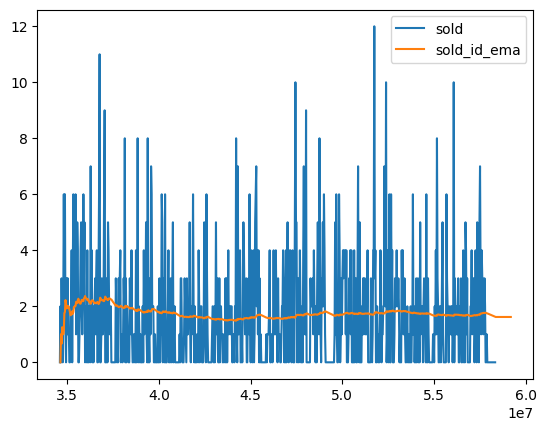

In [87]:
features[features['id'] == 'FOODS_3_827_WI_3_validation'][['sold', 'sold_id_ema']].plot()